Implementation of AGE \
D. Ulyanov et al. Adversarial generator-encoder networks, AAAI 2018\
https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewPaper/16568

In [1]:
import time
import torch
import random
from torch import cuda, device, nn, utils, optim
from torch.autograd import Variable
from torchsummary import summary
import torchvision as tv
from matplotlib import pyplot as plt

print(cuda.is_available())
device = device('cuda:0')
print(device)

#manualSeed = 999
#manualSeed = random.randint(1, 10000)
#print("Random Seed: ", manualSeed)
#random.seed(manualSeed)
#torch.manual_seed(manualSeed)

image_size = 16
nz = 128
nf = 32
nc = 3; 

True
cuda:0


In [2]:
class Encoder(nn.Module):
    def __init__(self, nc, nf, nz):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, nf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf, nf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf*2, nf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # for 16x16
            nn.AvgPool2d(2),
            
            # for 32x32
            #nn.Conv2d(nf*4, nz, 4, 2, 1, bias=True),
            #nn.AvgPool2d(2),
            
            # for 64x64
            #nn.Conv2d(nf*4, nf*8, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(nf*8),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Conv2d(nf*8, nz, 4, 1, 0, bias=True),
        )
        
    def forward(self, input):
        return self.net(input)
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

In [3]:
class Decoder(nn.Module):
    def __init__(self, nc, nf, nz):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz, nf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nf*8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(nf*8, nf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(nf*4, nf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.ReLU(True),
            
            # for 16x16
            nn.Conv2d(nf*2, nc, 1, bias=True),
            
            # for 32x32 and 64x64
            # state size. (ngf*2) x 16 x 16
            #nn.ConvTranspose2d(nf*2, nf, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(nf),
            #nn.ReLU(True),
            
            # for 32x32
            #nn.Conv2d(nf, nc, 1, bias=True),
            # for 64x64
            #nn.ConvTranspose2d(nf, nc, 4, 2, 1, bias=False),
            
            nn.Tanh(),
        )
    
    def forward(self, input):
        return self.net(input)
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

In [4]:
enc = Encoder(nc=nc, nf=nf, nz=nz).to(device)
summary(enc, (nc, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 32, 8, 8]           1,536
         LeakyReLU-2             [-1, 32, 8, 8]               0
            Conv2d-3             [-1, 64, 4, 4]          32,768
       BatchNorm2d-4             [-1, 64, 4, 4]             128
         LeakyReLU-5             [-1, 64, 4, 4]               0
            Conv2d-6            [-1, 128, 2, 2]         131,072
       BatchNorm2d-7            [-1, 128, 2, 2]             256
         LeakyReLU-8            [-1, 128, 2, 2]               0
         AvgPool2d-9            [-1, 128, 1, 1]               0
Total params: 165,760
Trainable params: 165,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.63
Estimated Total Size (MB): 0.70
-------------------------------------------

In [5]:
dec = Decoder(nc=nc, nf=nf, nz=nz).to(device)
summary(dec, (nz, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         524,288
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]         131,072
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10            [-1, 3, 16, 16]             195
             Tanh-11            [-1, 3, 16, 16]               0
Total params: 1,180,739
Trainable params: 1,180,739
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [6]:
"""
batch_size = 64

dataroot = '/raid/artem/tmp/celeba'
transform = tv.transforms.Compose([tv.transforms.Resize(image_size),
                                tv.transforms.CenterCrop(image_size),
                                tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = tv.datasets.ImageFolder(root=dataroot, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, drop_last=True)
print(len(dataloader))
"""

"\nbatch_size = 64\n\ndataroot = '/raid/artem/tmp/celeba'\ntransform = tv.transforms.Compose([tv.transforms.Resize(image_size),\n                                tv.transforms.CenterCrop(image_size),\n                                tv.transforms.ToTensor(),\n                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])\ndataset = tv.datasets.ImageFolder(root=dataroot, transform = transform)\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,\n                                         shuffle=True, num_workers=8, drop_last=True)\nprint(len(dataloader))\n"

In [7]:
#"""
batch_size = 64
#dataroot = '/raid/artem/data/cityscapes/dataset_16x/leftImg8bitAll'
dataroot = '/raid/artem/tmp/gta_256x128/train/'
transform = tv.transforms.Compose([tv.transforms.Resize(image_size),
                                tv.transforms.CenterCrop(image_size),
                                tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = tv.datasets.ImageFolder(root=dataroot, transform = transform)
dataloader = utils.data.DataLoader(dataset=dataset,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   num_workers=8,
                                   drop_last=True)
print(len(dataloader))
#"""

390


In [8]:
def kl_divergence(z1):
    z1 = z1.view(z1.size(0), -1)
    mu = z1.mean(dim=0)
    ex_zero_meaned = z1 - z1.mean(dim=0).expand_as(z1)
    var = ex_zero_meaned.pow(2).mean(dim=0)
    t1 = (var.pow(2) + mu.pow(2)) / 2
    t2 = -var.log()
    return (t1 + t2 - 0.5).mean()
    #return torch.mean(0.5 * (mu**2 + var**2 - 1) - torch.log(var))

def cos_similarity(z1, z2):
    cos = nn.CosineSimilarity(dim=1)
    return 2 - cos(z1, z2).mean()

def sample_z():
    zz = torch.FloatTensor(batch_size, nz, 1, 1)
    zz.data.normal_(0, 1)
    zz.data.div_(zz.data.norm(2, dim=1).unsqueeze_(-1).expand_as(zz))
    return zz

criterion_l1 = torch.nn.L1Loss()

In [9]:
enc = Encoder(nc=nc, nf=nf, nz=nz).to(device)
dec = Decoder(nc=nc, nf=nf, nz=nz).to(device)

In [10]:
lr = 2e-4
optimizer_dec = optim.Adam(dec.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_enc = optim.Adam(enc.parameters(), lr=lr, betas=(0.5, 0.999))

In [11]:
enc_losses = []
dec_losses = []

enc.apply(enc.weights_init)
dec.apply(dec.weights_init)

epochs = 100
lr_scheduler_enc = optim.lr_scheduler.MultiStepLR(optimizer_enc, [10], gamma=0.1)
lr_scheduler_dec = optim.lr_scheduler.MultiStepLR(optimizer_dec, [10], gamma=0.1)

print_iter = len(dataloader) / 2#20
for epoch in range(1, epochs + 1):
    epoch_start = time.time()
    
    for idx, (data, _) in enumerate(dataloader):
        
        start = time.time()
        #if idx == 1: break
        
        batch_size = data.shape[0]
        
        x = Variable(data).to(device)
        ex = enc(x)
        enc_ex_loss = kl_divergence(ex)
                
        gex = dec(ex)
        enc_gex_loss = criterion_l1(gex, x)
        
        z = Variable(sample_z()).to(device)
        gz = dec(z)
        egz = enc(gz)
        
        enc_egz_loss = -kl_divergence(egz)
        
        #enc_cos_loss = cos_similarity(egz, z)
                
        enc_loss = enc_ex_loss + 100*enc_gex_loss + enc_egz_loss #+ enc_cos_loss
        enc.zero_grad()
        #enc_loss.backward(retain_graph=True)
        enc_loss.backward()
        optimizer_enc.step()
        enc_losses.append(enc_loss.item())
        
        # Dec
        for i in range(0,3):
            z = Variable(sample_z()).to(device)
            gz = dec(z)
            egz = enc(gz)

            dec_egz_loss = kl_divergence(egz)

            dec_cos_loss = cos_similarity(egz, z)
            
            #ex = enc(x)
            #gex = dec(ex)
            #dec_gex_loss = criterion_l1(gex, x)

            dec_loss = dec_egz_loss + 10*dec_cos_loss #+ dec_gex_loss
            dec.zero_grad()
            #dec_loss.backward(retain_graph=True)
            dec_loss.backward()
            optimizer_dec.step()
            dec_losses.append(dec_loss.item())

        if (not (idx % print_iter)) or (not (idx % len(dataloader))):
            print('[%d/%d;%d/%d]: loss_dec: %.3f, loss_enc: %.3f'
              % (idx, len(dataloader),
                 (epoch), epochs, 
                 torch.mean(torch.FloatTensor(dec_losses)), 
                 torch.mean(torch.FloatTensor(enc_losses))))
    print('Time: ', time.time() - epoch_start)
    for param_group in optimizer_enc.param_groups:
        print('lr:', param_group['lr'])
    lr_scheduler_enc.step()
    lr_scheduler_dec.step()

[0/390;1/100]: loss_dec: 22.032, loss_enc: 38.529
[195/390;1/100]: loss_dec: 18.009, loss_enc: 27.718
Time:  34.94452142715454
lr: 0.0002
[0/390;2/100]: loss_dec: 18.105, loss_enc: 21.304
[195/390;2/100]: loss_dec: 17.963, loss_enc: 19.515
Time:  34.7847216129303
lr: 0.0002
[0/390;3/100]: loss_dec: 17.765, loss_enc: 18.527
[195/390;3/100]: loss_dec: 17.632, loss_enc: 17.689
Time:  35.18981599807739
lr: 0.0002
[0/390;4/100]: loss_dec: 17.568, loss_enc: 17.031
[195/390;4/100]: loss_dec: 17.545, loss_enc: 16.584
Time:  35.75420379638672
lr: 0.0002
[0/390;5/100]: loss_dec: 17.558, loss_enc: 16.188
[195/390;5/100]: loss_dec: 17.571, loss_enc: 15.815
Time:  36.6765079498291
lr: 0.0002
[0/390;6/100]: loss_dec: 17.578, loss_enc: 15.563
[195/390;6/100]: loss_dec: 17.592, loss_enc: 15.419
Time:  36.28466987609863
lr: 0.0002
[0/390;7/100]: loss_dec: 17.610, loss_enc: 15.263
[195/390;7/100]: loss_dec: 17.628, loss_enc: 15.111
Time:  35.16787028312683
lr: 0.0002
[0/390;8/100]: loss_dec: 17.637, los

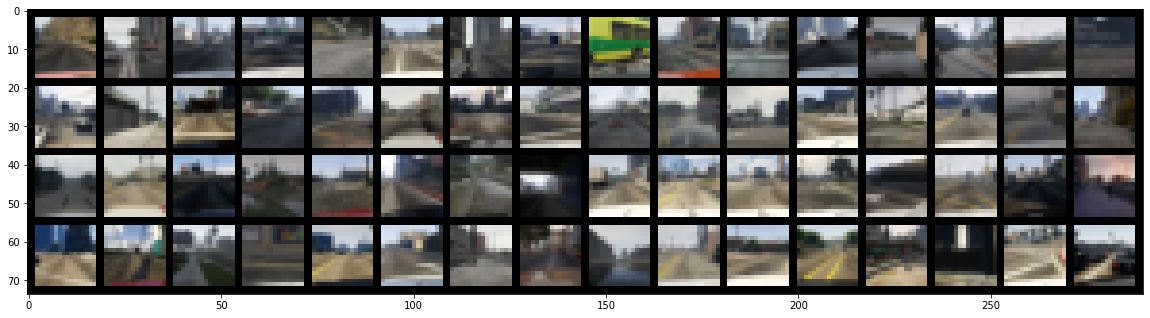

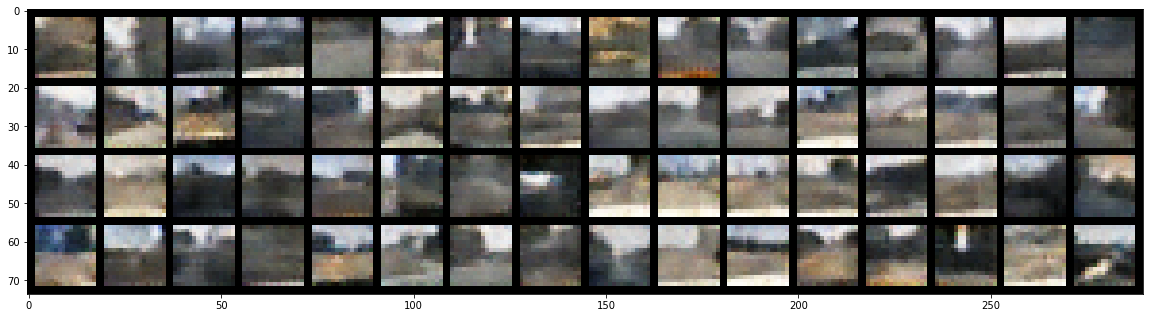

In [12]:
idx, (data, label) = next(enumerate(dataloader))
x = Variable(data)

plt.figure(figsize=(20,20))
plt.imshow(tv.utils.make_grid(data[:64], nrow=16, normalize=True).permute(1, 2, 0))
plt.show()

z = enc(x.to(device))
rec = dec(z)
y = rec.detach().cpu()

plt.figure(figsize=(20,20))
plt.imshow(tv.utils.make_grid(y[:64],  nrow=16, normalize=True).permute(1, 2, 0))
plt.show()

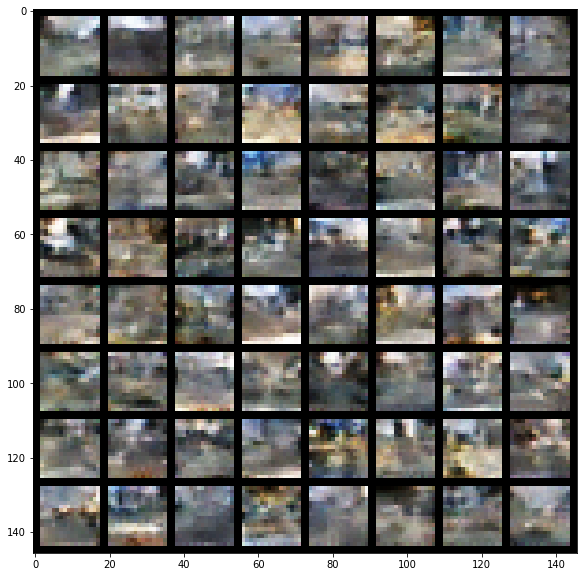

In [13]:
z1 = Variable(sample_z()).to(device)
#z1 = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
#z1 = normalize(z)
y1 = dec(z1).detach().cpu()
plt.figure(figsize=(10,10))
plt.imshow(tv.utils.make_grid(y1[:64],  nrow=8, normalize=True).permute(1, 2, 0)); plt.show()

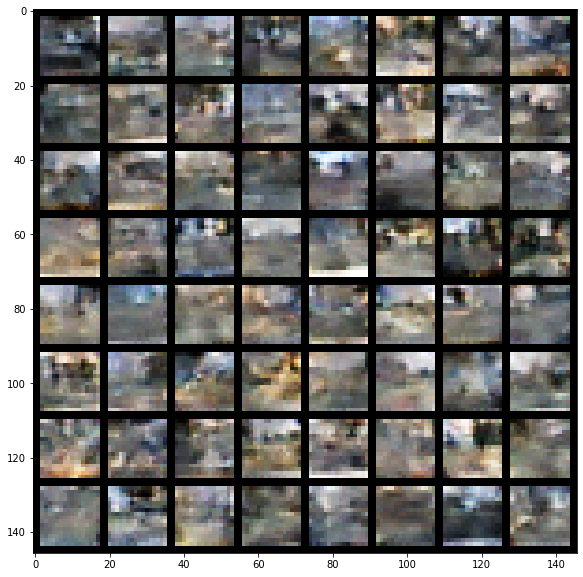

In [14]:
loc = torch.zeros(nz*batch_size)
scale = torch.ones(nz*batch_size)
mvn = torch.distributions.MultivariateNormal(loc, scale_tril=torch.diag(scale))
z2 = Variable(mvn.sample().view(batch_size, nz, 1, 1).to(device))
z2 = z2.div(z2.norm(2, dim=0).expand_as(z2))
y2 = dec(z2).detach().cpu()

plt.figure(figsize=(10,10))
plt.imshow(tv.utils.make_grid(y2[:64],  nrow=8, normalize=True).permute(1, 2, 0)); plt.show()